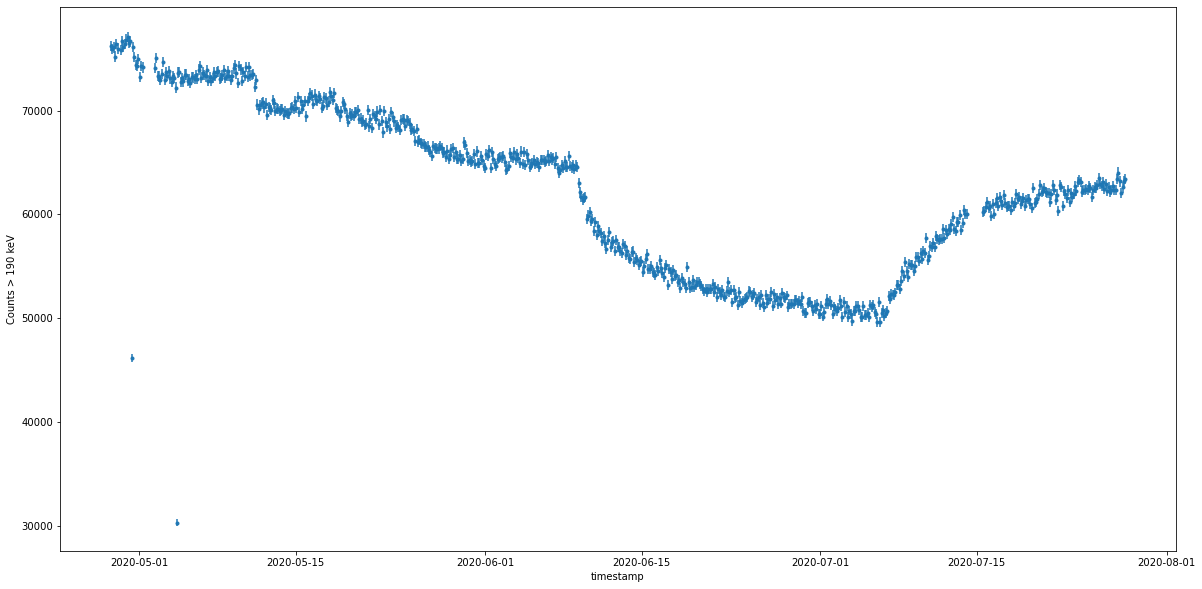

In [1]:
from jax.config import config
config.update("jax_enable_x64",True)
import numpy as np
from numpy.linalg import inv
from scipy.linalg import expm
from scipy.optimize import minimize
import json
import matplotlib.pyplot as plt
import os
import datetime

path_spectra = os.path.join('data','gamma-spectra')

def read_spectrum_directory_json(path):
    spectra = []
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path,file)):
            with open(os.path.join(path,file),'r') as file:
                json_obj = json.load(file)
                spectra.append(json_obj)
    return spectra


'''
Reading Data
'''
spectra_open = read_spectrum_directory_json(os.path.join(path_spectra,'open_source'))
spectra_bg = read_spectrum_directory_json(os.path.join(path_spectra,'background'))

'''
Sort actual spectra according to recorded starting timestamps
'''
timestamps = [datetime.datetime.strptime(i['timestamp'],'%Y-%m-%d %H:%M:%S') for i in spectra_open]
sorted_id = np.argsort(timestamps)
spectra_open = list(np.array(spectra_open)[sorted_id])

# spectrum at id 40 is corrupted, so remove it
spectra_open.remove(spectra_open[40])

'''
Preprocess spectra - find their sums above a certain energy threshold ( roughly 190 keV) which we know corresponds to roughly bin 1200
'''
cutoff_bin = 1200


# find count rate and uncertainty in background spectrum
rate_bg = [np.sum(np.array(i['data'])[cutoff_bin:])/i['livetime'] for i in spectra_bg]
sigma_rate_bg = [np.sqrt(np.sum(np.array(i['data'])[cutoff_bin:]))/i['livetime'] for i in spectra_bg]

# compute net counts and uncertainty for actual spectra
counts_open = [(np.sum(np.array(i['data'])[cutoff_bin:])/i['livetime'] - rate_bg[0])*i['livetime'] for i in spectra_open]
sigma_counts_open = [
    np.sqrt((np.sum(np.array(i['data'])[cutoff_bin:])/i['livetime']**2)+sigma_rate_bg[0]**2)*i['livetime'] for i in spectra_open
]


'''
Compute timedeltas (i.e. time between spectrum acquisition that was not spent for counting/integration)
and mangle input data
'''

realtimes = np.array([i['realtime'] for i in spectra_open])
timestamps = np.array([datetime.datetime.strptime(i['timestamp'],'%Y-%m-%d %H:%M:%S') for i in spectra_open]).astype('datetime64')
t0 = timestamps[0]
date_endpoint = timestamps + np.array(realtimes).astype('timedelta64[s]')
dts = []
rts = []
y_obs = [] # y_obs will hold the observations that will be feed to the filtering/smoothing algorithms - dead time corrected net counts
for i in range(len(spectra_open)):
    if i == 0:
        dts.append(0.)
        rts.append(realtimes[i]/86400)
        y_obs.append(counts_open[i])
    else:
        dts.append((timestamps[i]-date_endpoint[i-1]).astype('timedelta64[s]').astype('float')/86400)
        rts.append(realtimes[i]/86400)
        y_obs.append(counts_open[i])

dts = np.array(dts)
rts = np.array(rts)
y_obs = np.array(y_obs)


'''
Read humidity and temperature of environment
'''
import sqlite3
db = sqlite3.connect(os.path.join('data','temprh.db'))
cur = db.cursor()
query = "SELECT * FROM Temperature"
rh_data = np.array(cur.execute(query).fetchall())

'''
Plot processed experimental data
'''
plt.figure(figsize=(20,10))
plt.errorbar(timestamps,y_obs,sigma_counts_open,fmt='.')
plt.ylabel('Counts > 190 keV')
plt.xlabel('timestamp')
plt.show()

In [2]:
'''
Utilities: Gaussian mixture reduction algorithm
'''

import jax
import jax.numpy as jnp
from functools import partial
from jax import lax
from jax.scipy.special import logsumexp

'''
2023: Refactor for JAX deprecations after version 0.3.15
'''

'''
_____________________________________________________________________________________________________________________________________
Simple and very naive JAX implementation of Runnall's mixture reduction algorithm based on an upper bound of the KL-divergence below
'''

@jax.jit
def merge_gaussians(weight1,weight2,mean1,mean2,cov1,cov2):
    '''
    Function that merges two Gaussian distributions (moment matching) specified by weight1, weight2 and
    mean vectors mean1 mean2
    covariance matrices cov1 cov2
    '''
    w = jnp.array([weight1,weight2])
    wij = logsumexp(w) # merged log_weight
    w = jnp.exp(w - logsumexp(w)) # normalize logweights and compute exponential : sum(w) == 1!
    new_mu = w[0]*mean1 + w[1]*mean2
    mean_diff = mean1-mean2
    new_cov = w[0]*cov1 + w[1]*cov2 + w[0]*w[1]*jnp.outer(mean_diff,mean_diff)
    return wij, new_mu, new_cov

@jax.jit
def KL_upper_bound(weight1,weight2,mean1,mean2,cov1,cov2):
    '''
    Computes an upper bound value of the KL-divergence between two Gaussian specified by mean vectors mean1, mean2, covariance matrices cov1, cov2
    and weighted by weight1, weight2
    '''
    merge_weight,merge_mean,merge_cov = merge_gaussians(weight1,weight2,mean1,mean2,cov1,cov2)
    cov1_cholesky = jnp.linalg.cholesky(cov1)
    cov2_cholesky = jnp.linalg.cholesky(cov2)
    merge_cov_cholesky = jnp.linalg.cholesky(merge_cov)
    KLupper = jnp.exp(merge_weight)*jnp.sum(jnp.diag(merge_cov_cholesky)) - jnp.exp(weight1)*jnp.sum(jnp.diag(cov1_cholesky)) - jnp.exp(weight2)*jnp.sum(jnp.diag(cov2_cholesky))
    return lax.cond(jnp.logical_or(jnp.isnan(weight1), jnp.isnan(weight2)), lambda _: jnp.inf,lambda _: KLupper, operand=None)


'''
This defines "helper" functions in the sence that double-vmapping i.e. vectorising above functions such that for 
some input of weights, means and covariances (i.e. a mixture of Gaussians) a matrix is computed that contains all the 
upper bounds of the KL-diverence (i.e. the output of the KL_upper_bound function) for each combination of them.

Note, that this is computationally convenvient but suboptimal, since this matrix is always symmetric and actually only the upper triangular values are needed
'''
KL_upper_b_shuffle1 = jax.jit(jax.vmap(KL_upper_bound,in_axes=(None,0,None,-1,None,-1)))
KL_upper_b_shuffle2 = jax.jit(jax.vmap(KL_upper_b_shuffle1,in_axes=(0,None,-1,None,-1,None)))

@jax.jit
def KLbound_matrix(weights,means,covs):
    return KL_upper_b_shuffle2(weights,weights,means,means,covs,covs)

@jax.jit
def find_least_dissimilar(measure_matrix):
    '''
    Finds the index of the two components that are to be merged in the Runalls algorithm in the triangular subspace of the "KL-divergence"-matrix
    '''
    triangular_indices = jnp.triu_indices(measure_matrix.shape[0],1)
    argmin = jnp.argmin(measure_matrix[triangular_indices])
    return triangular_indices[0][argmin],triangular_indices[1][argmin]

@jax.jit
def runalls_loop_func(i,s):
    KL_matrix = KL_upper_b_shuffle2(s["weights"],s["weights"],s["means"],s["means"],s["covs"],s["covs"])
    best_match_ind = find_least_dissimilar(KL_matrix)
    merged_weight,merged_mean,merged_cov = merge_gaussians(s["weights"][...,best_match_ind[0]],
                                                           s["weights"][...,best_match_ind[1]],
                                                           s["means"][...,best_match_ind[0]],
                                                           s["means"][...,best_match_ind[1]],
                                                           s["covs"][...,best_match_ind[0]],
                                                           s["covs"][...,best_match_ind[1]])
    s["weights"] = s["weights"].at[best_match_ind[0]].set(merged_weight)
    s["weights"] = s["weights"].at[best_match_ind[1]].set(jnp.nan)
    s["means"] = s["means"].at[...,best_match_ind[0]].set(merged_mean)
    s["covs"] = s["covs"].at[...,best_match_ind[0]].set(merged_cov)
    return s

@partial(jax.jit,static_argnums=(3,4))
def runnalls_reduce_naive(log_weights,means,covs,n_original_components,n_target_components):
    '''
    Actual runnalls reduction main loop
    '''
    weights = log_weights - logsumexp(log_weights)# normalize input logweights
    init_s = dict(weights=weights,means=means,covs=covs)
    s = lax.fori_loop(0,n_original_components-n_target_components,runalls_loop_func,init_s)
    sorted_ind = jnp.argsort(s["weights"])
    return s["weights"][sorted_ind][:n_target_components],s["means"][...,sorted_ind][...,:n_target_components],s["covs"][...,sorted_ind][...,:n_target_components]


In [3]:
'''
Forward and backward step functions as defined in the paper
'''

from IntegrationDiscretization import discretize_timestep, discretize_measurement_step
from functools import partial
import jax
import jax.numpy as jnp
from jax.scipy.linalg import cho_solve,cho_factor
import numpy as np


@jax.jit
def integrating_forward_step_poisson(dt,rt,params,H,prior_mean_,prior_cov_,measurement,regularization):
    '''
    Predict forward model from prior_mean/prior_cov using dt,rt and the actual model matrices computed in external module (IntegrationDiscretization)
    and condition on measurement using H-mapping.
    IntegrationDiscretization is parametrized by parameter vector "params"
    '''
    Psi,U = discretize_timestep(dt,params)
    prior_mean = Psi@prior_mean_
    prior_cov = Psi@prior_cov_@Psi.T + U
    Psi,U,K,B,C = discretize_measurement_step(rt,params)
    #U += jnp.array([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,1]])*1e-3
    U += regularization
    predicted_meas_mean = H@K@prior_mean
    residual = measurement - predicted_meas_mean
    # the 180000 is from the background noise assuming poisson distribution
    residual_cov = H@K@prior_cov@K.T@H.T + H@B@H.T + jnp.diag(jnp.where(predicted_meas_mean.flatten()>1,1.1*predicted_meas_mean.flatten(),1)) + 180000.
    cross_cov = H@K@prior_cov@Psi.T + H@C.T
    cholesky_factor = cho_factor(residual_cov)
    gain = cho_solve(cholesky_factor,cross_cov).T
    posterior_mean = Psi@prior_mean + gain@residual
    posterior_cov = Psi@prior_cov@Psi.T + U - gain@cross_cov
    ll = -0.5*residual.T@cho_solve(cholesky_factor,residual)
    ll -= jnp.sum(jnp.log(jnp.diag(cholesky_factor[0])))
    ll -= H.shape[0]/2 * jnp.log(2*jnp.pi)
    return ll[0,0],posterior_mean, (posterior_cov+posterior_cov.T)/2 # make sure posterior_cov is symmetric

'''
Define a function which "batches" these forward computation for a 
 - set of models defined by "params" and "H"
 - set of prior distributions befined by "prior_mean" and "prior_cov" 
above.
'''
#batched_forward_step = jax.vmap(integrating_forward_step_poisson,in_axes=(None,None,-1,-1,None,None,None,None),out_axes=(-1,-1,-1))
#batch_forward_step = jax.vmap(batched_forward_step,in_axes=(None,None,None,None,-1,-1,None,None),out_axes=(-1,-1,-1))

'''
Analogous to the above for the "backward steps"/propagation as in the RTS-smoother
'''
@jax.jit
def backward_step_lds(dt,rt,params,filtered_mean,filtered_cov,prev_smoothed_mean,prev_smoothed_cov,regularization):
    Psi,U = discretize_timestep(dt+rt,params)
    U += regularization
    prior_mean = Psi@filtered_mean
    prior_cov = Psi@filtered_cov@Psi.T + U
    cholesky_factor = cho_factor(prior_cov)
    gain = cho_solve(cholesky_factor,Psi@filtered_cov).T
    residual = prev_smoothed_mean - prior_mean
    ll = -0.5*residual.T@cho_solve(cholesky_factor,residual)
    ll -= jnp.sum(jnp.log(jnp.diag(cholesky_factor[0])))
    ll -= filtered_mean.shape[0]/2 * jnp.log(2*jnp.pi)
    X = np.eye(4) - gain@Psi
    return ll[0,0],filtered_mean + gain@residual, X@filtered_cov@X.T + gain@(U + prev_smoothed_cov)@gain.T

'''
Analogoues to above, batching along different
 - models
 - priors
to compute all possible combos.
'''
#batch_backward_step_lds = jax.vmap(backward_step_lds,in_axes=(None,None,None,-1,-1,None,None,None),out_axes=(-1,-1,-1))
#batch_backward_step_lds = jax.vmap(batch_backward_step_lds,in_axes=(None,None,-1,None,None,-1,-1,None),out_axes=(-1,-1,-1))


@jax.jit
def collapse_MVMix_to_MV(log_weights,means,covs):
    '''
    Utility function that collapses a mixture of multivariate Gaussians to a single Gaussian
    '''
    weights = jnp.exp(log_weights - logsumexp(log_weights))
    mu = jnp.sum(weights*means,axis=-1)
    cov_temp = jnp.zeros_like(covs)
    for i in range(covs.shape[-1]):
        cov_temp = jax.ops.index_add(cov_temp,jax.ops.index[...,i],weights[i]*(covs[...,i]+means[...,i]@means[...,i].T))
    return mu, jnp.sum(cov_temp,axis=-1) - mu@mu.T

batch_collapse = jax.vmap(collapse_MVMix_to_MV,in_axes=(0,-2,-2),out_axes=(-1))


@jax.jit
def normalize_2comp_transition_matrix(params_):
    '''
    Utility function for parameter transforms on the model index transition matrix
    '''
    params = jax.nn.sigmoid(params_)
    transition = jnp.diag(params)
    transition = transition.at[0,1].set(1-transition[0,0]) #jax.ops.index_update(transition,jax.ops.index[0,1],1-transition[0,0])
    transition = transition.at[1,0].set(1-transition[1,1]) #jax.ops.index_update(transition,jax.ops.index[1,0],1-transition[1,1])
    return transition

In [27]:
    
'''
Now we want to allow for mixtures in the forward pass, and use Runnall's reduction algorithm to reduce the number of components after each step.
'''

'''
First, multiple vmap for each batch dimension of the forward step function.
We obtain thus a function, that will compute the forward step for each combination of
parameter vector, prior, prior component index
'''
#integrating_forward_step_poisson(dt,rt,params,H,prior_mean_,prior_cov_,measurement,regularization):
batch_forward_step_mix = jax.vmap(integrating_forward_step_poisson,in_axes=(None,None,-1,-1,None,None,None,None),out_axes=(-1,-1,-1)) # batch over different filters (e.g. parameters)
batch_forward_step_mix = jax.vmap(batch_forward_step_mix,in_axes=(None,None,None,None,-1,-1,None,None),out_axes=(-1,-1,-1)) # batch over different priors
batch_forward_step_mix = jax.vmap(batch_forward_step_mix,in_axes=(None,None,None,None,-1,-1,None,None),out_axes=(-1,-1,-1)) # batch over different components of those priors
# I.e. the dimensinality of the return values in batch_forward_step_mix are this
# (state dimension,1,filter_index,prior_index,prior_component) or following notation in Barber et. al. Journal of Machine Learning Research 7 (2006) 2515-2540
# we have (xdim,1,s_t,s_t-1,I_t-1)

# Batch also mixture reduction
batch_runalls = jax.vmap(runnalls_reduce_naive,in_axes=(0,-2,-2,None,None),out_axes=(0,-2,-2))


@partial(jax.jit,static_argnums=(0,1))
def forward_pass_loop_body(n_comps,n_filters,i,s):
    ll,m,c = batch_forward_step_mix(s["dts"][i],s["rts"][i],s["params"],s["H"],s["m"],s["c"],s["y_obs"][i,...],s["regularization"])
    log_p = s["log_w"] + ll + s["log_transition"].T[:,:,jnp.newaxis] + s["log_p"][:,jnp.newaxis]
    marginal_loglike = logsumexp(log_p)
    s["marginal_log_likelihood"] += marginal_loglike
    log_p = log_p - marginal_loglike
    s["log_p"] = logsumexp(logsumexp(log_p,axis=-1),axis=-1)
    s["log_w"],s["m"],s["c"] = batch_runalls(log_p.reshape(n_filters,n_comps*n_filters),m.reshape(*m.shape[:2],n_filters,n_comps*n_filters),c.reshape(*c.shape[:2],n_filters,n_comps*n_filters),n_comps*n_filters,n_comps)
    s["filtered_means"] = s["filtered_means"].at[i,...].set(s["m"])
    s["filtered_covs"] = s["filtered_covs"].at[i,...].set(s["c"])
    s["filtered_log_weights"] = s["filtered_log_weights"].at[i,...].set(s["log_w"])
    s["filtered_logprobs"] = s["filtered_logprobs"].at[i,...].set(s["log_p"])
    return s
    
@partial(jax.jit,static_argnums=(0,1))
def switching_forward_pass_mixture(n_comps,n_filters,dts,rts,y_obs,params_,H,prior_mean,prior_cov,prior_probs,regularization):
    '''
    Same as switching_forward_pass, except that we allow for mixtures in the model specific PDFs
    '''
    ''' Parameter extraction and transformation'''
    p_ = jax.nn.softplus(params_[:1,:])
    init_s = dict()
    init_s["params"] = jnp.concatenate([p_.T,jnp.array([[p_[0,0],0.01]]).T],axis=1) # p_[0,0]
    init_s["transition"] = normalize_2comp_transition_matrix(params_[-1,:])
    init_s["log_transition"] = jnp.log(init_s["transition"])
    ''' Construct initial values for sequential algorithm (broadcasting 1 component priors)'''
    init_s["m"] = jnp.stack([prior_mean for i in range(n_comps)],axis=-1)
    init_s["c"] = jnp.stack([prior_cov for i in range(n_comps)],axis=-1)
    init_s["log_w"] = jnp.zeros(shape=(n_filters,n_comps))
    #s.log_w = jax.ops.index_update(s.log_w,jax.ops.index[0,:],1.)
    #s.log_w = jax.ops.index_update(s.log_w,jax.ops.index[1:,:],-1E6)
    init_s["log_w"] = init_s["log_w"] - logsumexp(init_s["log_w"])
    init_s["log_p"] = jnp.log(prior_probs)
    ''' "Allocate" output arrays of appropriate shape '''
    init_s["N"] = dts.shape[0]
    init_s["filtered_means"] = jnp.zeros(shape=(dts.shape[0],*prior_mean.shape,n_comps))
    init_s["filtered_covs"] = jnp.zeros(shape=(dts.shape[0],*prior_cov.shape,n_comps))
    init_s["filtered_log_weights"] = jnp.zeros(shape=(dts.shape[0],prior_mean.shape[-1],n_comps))
    init_s["filtered_logprobs"] = jnp.zeros(shape=(dts.shape[0],*prior_probs.shape))
    init_s["marginal_log_likelihood"] = 0.
    init_s["n_comps"] = n_comps
    init_s["n_filters"] = n_filters
    init_s["dts"] = dts
    init_s["rts"] = rts
    init_s["H"] = H
    init_s["y_obs"] = y_obs
    init_s["regularization"] = regularization
    ''' Loop over data '''
    loop_func = partial(forward_pass_loop_body,n_comps,n_filters)
    s = lax.fori_loop(0,init_s["N"],loop_func,init_s)
    return -s["marginal_log_likelihood"],(s["filtered_means"],s["filtered_covs"],s["filtered_log_weights"],s["filtered_logprobs"])


'''
Generate batched function
'''
batch_backward_mix = jax.vmap(backward_step_lds,in_axes=(None,None,None,-1,-1,None,None,None),out_axes=(-1,-1,-1)) # Batch over s
batch_backward_mix = jax.vmap(batch_backward_mix,in_axes=(None,None,None,-1,-1,None,None,None),out_axes=(-1,-1,-1)) # Batch over prior components, i
batch_backward_mix = jax.vmap(batch_backward_mix,in_axes=(None,None,-1,None,None,-1,-1,None),out_axes=(-1,-1,-1)) # Batch over s'
batch_backward_mix = jax.vmap(batch_backward_mix,in_axes=(None,None,None,None,None,-1,-1,None),out_axes=(-1,-1,-1)) # Batch over j

# Shape is thus (s,i,s',j)
    
@partial(jax.jit,static_argnums=(0,1))
def backward_pass_loop_body(n_comps,n_filters,k,s):
    i = s["N"] - 2 - k
    ll,m,c = batch_backward_mix(s["dts"][i+1],s["rts"][i+1],s["params"],s["fmean"][i,...],s["fcov"][i,...],s["m"],s["c"],s["regularization"])
    log_p = ll + s["flog_w"][i,:,:,jnp.newaxis,jnp.newaxis] + s["flog_p"][i,:,jnp.newaxis,jnp.newaxis,jnp.newaxis] + s["log_transition"][:,jnp.newaxis,:,jnp.newaxis]
    log_p = log_p - logsumexp(log_p,axis=(0,1)) + s["log_p"][jnp.newaxis,jnp.newaxis,:,jnp.newaxis] + s["log_w"][jnp.newaxis,jnp.newaxis,:,:]
    s["log_p"] = logsumexp(log_p,axis=(1,2,3))
    s["log_w"],s["m"],s["c"] = batch_runalls(log_p.reshape(n_filters,n_comps*n_filters*n_comps),m.reshape(*m.shape[:2],n_filters,n_comps*n_filters*n_comps),c.reshape(*c.shape[:2],n_filters,n_comps*n_filters*n_comps),n_comps*n_filters*n_comps,n_comps)
    s["smoothed_means"] = s["smoothed_means"].at[i,...].set(s["m"])
    s["smoothed_covs"] = s["smoothed_covs"].at[i,...].set(s["c"])
    s["smoothed_logweights"] = s["smoothed_logweights"].at[i,...].set(s["log_w"])
    s["smoothed_logprob"] = s["smoothed_logprob"].at[i,...].set(s["log_p"])
    return s
    
@partial(jax.jit,static_argnums=(0,1))
def expectation_correction_mixture(n_comps,n_filters,dts,rts,params_,fmean,fcov,flog_w,flogprob,regularization):
    ''' Parameter extraction and transformation'''
    p_ = jax.nn.softplus(params_[:1,:])
    init_s = dict()
    init_s["params"] = jnp.concatenate([p_.T,jnp.array([[p_[0,0],0.01]]).T],axis=1) # 
    init_s["transition"] = normalize_2comp_transition_matrix(params_[-1,:])
    init_s["log_transition"] = jnp.log(init_s["transition"])
    ''' Construct initial values for sequential algorithm (broadcasting 1 component priors)'''
    init_s["m"], init_s["c"], init_s["log_w"], init_s["log_p"] = fmean[-1],fcov[-1],flogw[-1], flogprob[-1]
    init_s["N"] = dts.shape[0]
    init_s["smoothed_means"] = jnp.zeros(shape=fmean.shape)
    init_s["smoothed_covs"] = jnp.zeros(shape=fcov.shape)
    init_s["smoothed_logweights"] = jnp.zeros(shape=flogw.shape)
    init_s["smoothed_logprob"] = jnp.zeros(shape=flogprob.shape)
    init_s["smoothed_means"] = init_s["smoothed_means"].at[-1,...].set(init_s["m"]) #jax.ops.index_add(s.smoothed_means,jax.ops.index[-1,...],s.m)
    init_s["smoothed_covs"] = init_s["smoothed_covs"].at[-1,...].set(init_s["c"]) #jax.ops.index_add(s.smoothed_covs,jax.ops.index[-1,...],s.c)
    init_s["smoothed_logweights"] = init_s["smoothed_logweights"].at[-1,...].set(init_s["log_w"]) #jax.ops.index_add(s.smoothed_logweights,jax.ops.index[-1,...],s.logw)
    init_s["smoothed_logprob"] = init_s["smoothed_logprob"].at[-1,...].set(init_s["log_p"]) #jax.ops.index_add(s.smoothed_logprob,jax.ops.index[-1,...],s.log_p)
    init_s["dts"] = dts
    init_s["rts"] = rts
    init_s["fmean"] = fmean
    init_s["fcov"] = fcov
    init_s["flog_p"] = flogprob
    init_s["regularization"] = regularization
    init_s["flog_w"] = flog_w
    loop_body = partial(backward_pass_loop_body,n_comps,n_filters)
    s = lax.fori_loop(0,init_s["N"]-2,loop_body,init_s)
    return s["smoothed_means"],s["smoothed_covs"],s["smoothed_logweights"],s["smoothed_logprob"]

In [28]:
'''
Statistical Utilities
'''


from tensorflow_probability.substrates.jax import math as tfp_math
from jax.scipy.stats import norm

root_finder = tfp_math.find_root_chandrupatla

vectorized_normcdf = jax.vmap(norm.cdf,in_axes=(None,-1,-1))

@partial(jax.jit,static_argnums=(4))
def marginal_cdf_MVMix(x,weights,means,covs,component):
    '''
    Marginalized (over components) cumulative density of multivariate normal mixture
    '''
    cdfs = vectorized_normcdf(x,means[component,0,:],covs[component,component,:])
    return jnp.sum(weights*cdfs)

@partial(jax.jit,static_argnums=(3))
def find_CI(log_weights,means,covs,component,confidence_level):
    '''
    Numerical root finding to compute CI from CDF
    '''
    a = (1-confidence_level)/2
    b = 1-(1-confidence_level)/2
    weights = jnp.exp(log_weights)
    m = jnp.mean(means[component,0,:])
    @jax.jit
    def objective(x):
        return marginal_cdf_MVMix(x,weights,means,covs,component)-a
    lower = root_finder(objective,-1000*m,1000*m)
    @jax.jit
    def objective(x):
        return marginal_cdf_MVMix(x,weights,means,covs,component)-b
    upper = root_finder(objective,-1000*m,1000*m)
    return jnp.array([lower[0],upper[0]])

@partial(jax.jit,static_argnums=(3))
def find_median(log_weights,means,covs,component):
    '''
    Find median of Gaussian mixture
    '''
    a = 0.5
    weights = jnp.exp(log_weights)
    m = jnp.mean(means[component,0,:])
    @jax.jit
    def objective(x):
        return marginal_cdf_MVMix(x,weights,means,covs,component)-a
    lower = root_finder(objective,-1000*m,1000*m)
    return jnp.array([lower[0]])

vectorized_CI = jax.vmap(find_CI,in_axes=(0,0,0,None,None))
vectorized_median = jax.vmap(find_median,in_axes=(0,0,0,None))

In [29]:
p_opt = jnp.array([[  2.61218171, 160.38894216],
                    [  2.44784069,   4.56409291]])

regularization = jnp.array([
    [0.,0,0,0],
    [0.,0.,0,0],
    [0,0,0.1,0.],
    [0.,0,0,1.]
])*0.

# switching_forward_pass_mixture(n_comps,n_filters,dts,rts,y_obs,params_,H,prior_mean,prior_cov,prior_probs,regularization):

In [30]:
# Optimized paramaters - see last cell of this notebook for method
p_opt = jnp.array([[  2.01981531, 372.24130485],
       [  2.19786273,   4.64998033]])

# known from external sources with an uncertainty of 1 %
H = jnp.array([[12285.4122856,     0.       ,     0.       ,     0.       ]])

# known from external sources
prior_mean = np.array([
    [50.],
    [104.],
    [54.],
    [0.]
])

# prior assumptions on covariance
prior_cov = np.eye(4)*500.
prior_cov[1,1] = 0.16
prior_probs = np.array([0.5,0.5])



# broadcasting to appropriate dimensions
prior_mean_ = np.stack([prior_mean,prior_mean],axis=-1)
prior_cov_ = np.stack([prior_cov,prior_cov],axis=-1)
H_ = np.stack([H,H],axis=-1)
y_obs = jnp.array(y_obs).reshape(-1,1,1)

# first filtering/smoothing pass to perform jit compilation
_,(fm,fc,flogw,flogp) = switching_forward_pass_mixture(5,2,dts,rts,y_obs,p_opt,H_,prior_mean_,prior_cov_,prior_probs,regularization)
sm,sc,slogw,slogp = expectation_correction_mixture(5,2,dts,rts,p_opt,fm,fc,flogw,flogp,regularization)

In [31]:
'''
Construction of sigma points in H and filtering/smoothing main loop for each of those points
'''
n_sigma_points = 5 

fm_uncH = jnp.zeros(shape=(*fm.shape,n_sigma_points))
fc_uncH = jnp.zeros(shape=(*fc.shape,n_sigma_points))
flogw_uncH = jnp.zeros(shape=(*flogw.shape,n_sigma_points))
flogp_uncH = jnp.zeros(shape=(*flogp.shape,n_sigma_points))

sm_uncH = jnp.zeros(shape=(*sm.shape,n_sigma_points))
sc_uncH = jnp.zeros(shape=(*sc.shape,n_sigma_points))
slogw_uncH = jnp.zeros(shape=(*slogw.shape,n_sigma_points))
slogp_uncH = jnp.zeros(shape=(*slogp.shape,n_sigma_points))

unc_H_stacked = jnp.stack([H_,H_+0.01*H_,H_-0.01*H_,H_+0.02*H_,H_-0.02*H_])

for k in range(n_sigma_points):
    _,(fm_,fc_,flogw_,flogp_) = switching_forward_pass_mixture(5,2,dts,rts,y_obs,p_opt,unc_H_stacked[k,:],prior_mean_,prior_cov_,prior_probs,regularization)
    sm_,sc_,slogw_,slogp_ = expectation_correction_mixture(5,2,dts,rts,p_opt,fm_,fc_,flogw_,flogp_,regularization)
    fm_uncH = fm_uncH.at[...,k].add(fm_) #jax.ops.index_add(fm_uncH,jax.ops.index[...,k],fm_)
    fc_uncH = fc_uncH.at[...,k].add(fc_) # jax.ops.index_add(fc_uncH,jax.ops.index[...,k],fc_)
    flogw_uncH = flogw_uncH.at[...,k].add(flogw_) #jax.ops.index_add(flogw_uncH,jax.ops.index[...,k],flogw_)
    flogp_uncH = flogp_uncH.at[...,k].add(flogp_) #jax.ops.index_add(flogp_uncH,jax.ops.index[...,k],flogp_)
    sm_uncH = sm_uncH.at[...,k].add(sm_) #jax.ops.index_add(sm_uncH,jax.ops.index[...,k],sm_)
    sc_uncH = sc_uncH.at[...,k].add(sc_) #jax.ops.index_add(sc_uncH,jax.ops.index[...,k],sc_)
    slogw_uncH = slogw_uncH.at[...,k].add(slogw_) #jax.ops.index_add(slogw_uncH,jax.ops.index[...,k],slogw_)
    slogp_uncH = slogp_uncH.at[...,k].add(slogp_) #jax.ops.index_add(slogp_uncH,jax.ops.index[...,k],slogp_)
    

# unnormalized log-density of the normal distribution: 
uncH_weights = jnp.array([
    -0.5*0.**2,
    -0.5*(1.)**2,
    -0.5*(-1.)**2,
    -0.5*(-2.)**2,
    -0.5*(2.)**2
])

norm_uncH_weights = uncH_weights - logsumexp(uncH_weights)

/tmp/ipykernel_8352/853330836.py:134: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


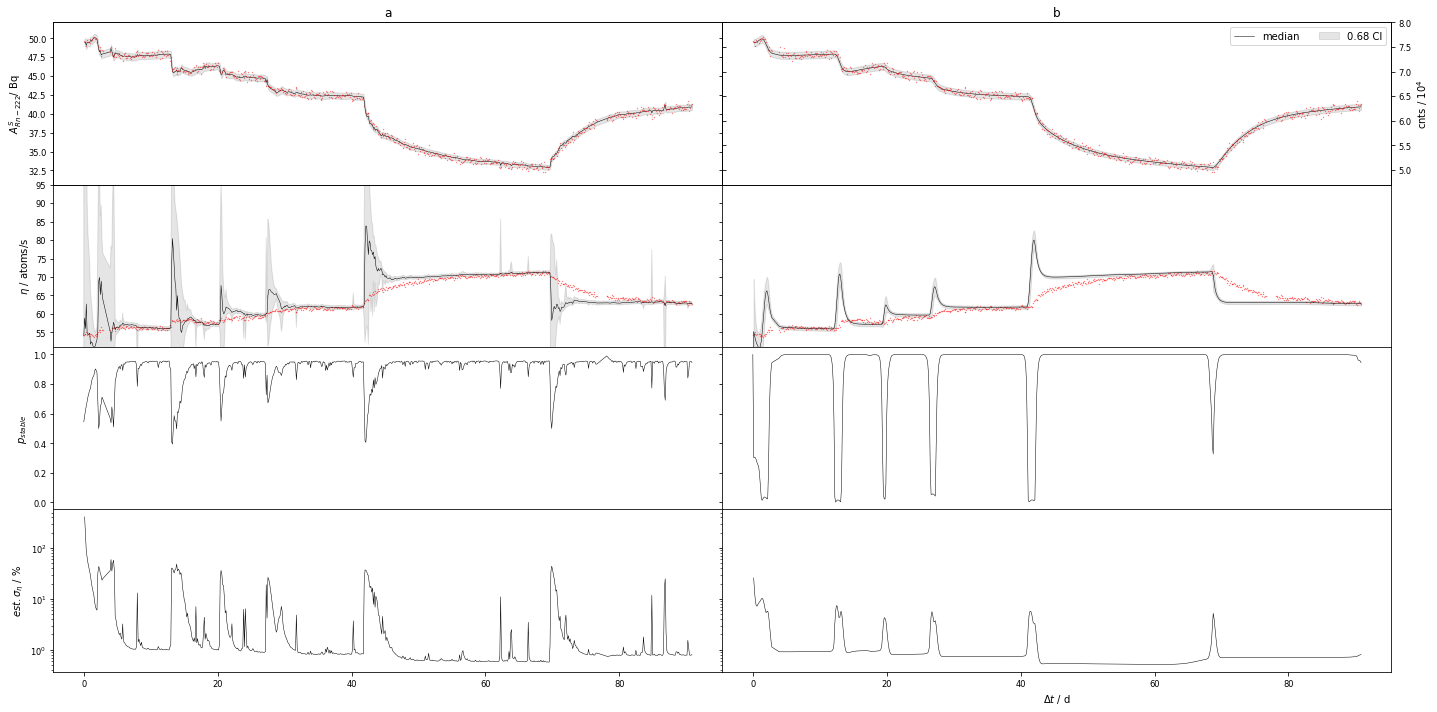

In [32]:
'''
Plotting results, Figure 3 in paper
'''

from matplotlib import rcParams
rcParams['lines.linewidth'] = 0.5
rcParams['xtick.labelsize'] = 'small'
rcParams['ytick.labelsize'] = 'small'

dt = date_endpoint - date_endpoint[0]
dt = dt.astype(np.float64)/(86400*1E6)




#fig,axarr = plt.subplots(4,2,figsize=(17.5/2.54,14/2.54),sharex='col',sharey='row') # output for paper
fig,axarr = plt.subplots(4,2,figsize=(20,10),sharex='col',sharey='row')

merged_uncH_logweights = (flogw_uncH[:,:,:,:] + flogp_uncH[:,:,:,None] + norm_uncH_weights[None,None,None,:]).reshape(709,50)
merged_uncH_mean = fm_uncH.reshape(709,4,1,50)
merged_uncH_cov = fc_uncH.reshape(709,4,4,50)
w_ = merged_uncH_logweights
m_ = merged_uncH_mean
c_ = merged_uncH_cov


'''
Rn
'''
axarr[0,0].set_title('a')
#axarr[2].set_ylim([45,90])
#axarr[1].plot(dt[1:],find_mean(w_,m_)[1:,0],color='r',alpha=1,label='mean')
ax = axarr[0,0].twinx()
ax.scatter(dt,y_obs.flatten()/10000,s=0.1,color='r',alpha=0.7)
axarr[0,0].plot(dt[1:],vectorized_median(w_,m_,c_,0)[1:],color='k',label='median')
ci = vectorized_CI(w_,m_,c_,0,0.68)

axarr[0,0].fill_between(dt[1:],ci[1:,1],ci[1:,0],color='k',alpha=0.1,interpolate=None,label='0.68 CI')
ax.set_yticklabels([])


axarr[0,0].set_ylim([47000/10800*86400/H[0,0],80000/10800*86400/H[0,0]])
#axarr[2].scatter(x,y_obs.flatten()/rts.flatten()/H[0,0],s=0.1,color='b')
#axarr[0,0].legend(ncol=3,loc=1)
axarr[0,0].set_ylabel(r'$A_{Rn-222}^{S}$/ Bq')

#ax.set_ylabel(r'cnts / $10^4$')

ax.set_ylim([4.7,8.0])
'''
eta
'''
#axarr[2].plot(dt,find_mean(w_,m_)[:,2],color='r',alpha=1,label='mean')
axarr[1,0].plot(dt,vectorized_median(w_,m_,c_,2),color='k',label='median')
ci = vectorized_CI(w_,m_,c_,2,0.68)
axarr[1,0].fill_between(dt,ci[:,1],ci[:,0],color='k',alpha=0.1,interpolate=None,label='0.68 CI')
axarr[1,0].set_ylim([51,90])
axarr[1,0].scatter(dt,104.-y_obs.flatten()/rts.flatten()/H[0,0],s=0.1,color='r',alpha=0.7)
#axarr[1,0].legend(ncol=3,loc=4)
axarr[1,0].set_ylabel(r'$\eta$ / atoms/s')


'''
probs
'''
axarr[2,0].plot(dt,jnp.exp(flogp)[:,1],color='k')
axarr[2,0].set_ylabel(r'$p_{stable}$')
axarr[2,0].set_xlabel(r'$\Delta t / d$')

'''
'''
axarr[3,0].plot(dt[1:],(ci[1:,1].flatten()-ci[1:,0].flatten().flatten())/2/vectorized_median(w_,m_,c_,2)[1:].flatten()*100,color='k')
axarr[3,0].set_yscale('log')
axarr[3,0].set_ylabel(r'$est. \sigma_{\eta}$ / %' )


merged_uncH_logweights = (slogw_uncH[:,:,:,:] + slogp_uncH[:,:,:,None] + norm_uncH_weights[None,None,None,:]).reshape(709,50)
merged_uncH_mean = sm_uncH.reshape(709,4,1,50)
merged_uncH_cov = sc_uncH.reshape(709,4,4,50)
w_ = merged_uncH_logweights
m_ = merged_uncH_mean
c_ = merged_uncH_cov


'''
Rn
'''
axarr[0,1].set_title('b')
#axarr[2].set_ylim([45,90])
#axarr[1].plot(dt[1:],find_mean(w_,m_)[1:,0],color='r',alpha=1,label='mean')
ax = axarr[0,1].twinx()
ax.set_ylabel(r'cnts / $10^4$')
ax.scatter(dt,y_obs.flatten()/10000,s=0.1,color='r',alpha=0.7)
axarr[0,1].plot(dt[1:],vectorized_median(w_,m_,c_,0)[1:],color='k',label='median')
ci = vectorized_CI(w_,m_,c_,0,0.68)
axarr[0,1].fill_between(dt[1:],ci[1:,1],ci[1:,0],color='k',alpha=0.1,interpolate=None,label='0.68 CI')


axarr[0,1].set_ylim([47000/10800*86400/H[0,0],80000/10800*86400/H[0,0]])
#axarr[2].scatter(x,y_obs.flatten()/rts.flatten()/H[0,0],s=0.1,color='b')
axarr[0,1].legend(ncol=3,loc=1)
#axarr[0,1].set_ylabel(r'$A_{Rn-222}^{S}$/ Bq')

ax.set_ylim([4.7,8.0])
'''
eta
'''
#axarr[2].plot(dt,find_mean(w_,m_)[:,2],color='r',alpha=1,label='mean')
axarr[1,1].plot(dt,vectorized_median(w_,m_,c_,2),color='k',label='median')
ci = vectorized_CI(w_,m_,c_,2,0.68)
axarr[1,1].fill_between(dt,ci[:,1],ci[:,0],color='k',alpha=0.1,interpolate=None,label='0.68 CI')
axarr[1,1].set_ylim([51,95])
axarr[1,1].scatter(dt,104.-y_obs.flatten()/rts.flatten()/H[0,0],s=0.1,color='r',alpha=0.7)
#axarr[1,1].legend(ncol=3,loc=4)
#axarr[1,1].set_ylabel(r'$\eta$ / atoms/s')


'''
probs
'''
axarr[2,1].plot(dt,jnp.exp(slogp_)[:,1],color='k')
#axarr[2,1].set_ylabel(r'$p_{stable}$')
axarr[2,1].set_xlabel(r'$\Delta t / d$')

'''
'''
axarr[3,1].plot(dt[1:],(ci[1:,1].flatten()-ci[1:,0].flatten().flatten())/2/vectorized_median(w_,m_,c_,2)[1:].flatten()*100,color='k')
axarr[3,1].set_yscale('log')
#axarr[3,1].set_ylabel(r'$est. \sigma_{\eta}$ / %' )

axarr[3,1].set_xlabel(r'$\Delta t $ / d')
fig.tight_layout()
fig.subplots_adjust(hspace=0.,wspace=0.0)
fig.show()
#fig.savefig('/mnt/e/RNK-2020/SMSI_SmoothedHPGe_uncertainH.svg')

In [23]:
from jax.example_libraries import optimizers
import jax
val_and_grad_func = jax.value_and_grad(switching_forward_pass_mixture,argnums=(5),has_aux=True)

params = jnp.array([
    [50.,100.],
    [25.,25.]
])

regularization = jnp.array([
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]
])

opt_init,opt_update,get_params = optimizers.adam(1.)
opt_state = opt_init(params)

def gradient_step(i,state,func):
    params = get_params(state)
    (neg_log_marg,_),grad = func(5,2,dts,rts,y_obs,params,H_,prior_mean_,prior_cov_,prior_probs,regularization)
    #if i % 100 == 0:
    print((neg_log_marg,params),end='\r')
    
    return opt_update(i,grad,state)

for k in range(1500):
    opt_state = gradient_step(k,opt_state,val_and_grad_func)

(Array(5554.31099748, dtype=float64), Array([[ 50., 100.],
(Array(5554.01213866, dtype=float64), Array([[ 49.00000005, 100.9999999 ],
(Array(5553.72830794, dtype=float64), Array([[ 48.00119545, 101.99763067],
(Array(5553.45993906, dtype=float64), Array([[ 47.00452978, 102.99113776],
(Array(5553.20745242, dtype=float64), Array([[ 46.01107663, 103.97862756],
(Array(5552.97123089, dtype=float64), Array([[ 45.02205853, 104.95806191],
(Array(5552.75160843, dtype=float64), Array([[ 44.03886795, 105.92725448],
(Array(5552.54880928, dtype=float64), Array([[ 43.06309029, 106.88386953],
(Array(5552.36276757, dtype=float64), Array([[ 42.09652658, 107.82542588],
(Array(5552.1929877, dtype=float64), Array([[ 41.14120631, 108.74931538],
(Array(5552.03888944, dtype=float64), Array([[ 40.19938157, 109.65284267],
(Array(5551.89591544, dtype=float64), Array([[ 39.27352721, 110.53325969],
(Array(5551.75940057, dtype=float64), Array([[ 38.36608749, 111.38801553],
(Array(5551.60286552, dtype=float64), Arra